# REINFORCE


In [ ]:
!apt-get install -y xvfb

!pip install \
  pygame \
  gym==0.23.1 \
  pytorch-lightning==1.6 \
  pyvirtualdisplay

#### Setup virtual display

In [1]:
from pyvirtualdisplay import Display
Display(visible=False, size=(1400, 900)).start()

#### Import the necessary code libraries

In [21]:
import copy
import torch
import random
import gym
import matplotlib

import numpy as np
import matplotlib.pyplot as plt

import torch.nn.functional as F

from collections import deque, namedtuple
from IPython.display import HTML
from base64 import b64encode

from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import IterableDataset
from torch.optim import AdamW

from pytorch_lightning import LightningModule, Trainer

from gym.wrappers import RecordVideo, RecordEpisodeStatistics, \
  NormalizeObservation, NormalizeReward


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
num_gpus = torch.cuda.device_count()

In [22]:
device

'cuda:0'

In [33]:
# def plot_policy(policy):
#   pos = np.linspace(-4.8, 4.8, 100)
#   vel = np.random.random(size=(10000, 1)) * 0.1
#   ang = np.linspace(-0.418, 0.418, 100)
#   ang_vel = np.random.random(size=(10000, 1)) * 0.1

#   g1, g2 = np.meshgrid(pos, ang)
#   grid = np.stack((g1,g2), axis=-1)
#   grid = grid.reshape(-1, 2)
#   grid = np.hstack((grid, vel, ang_vel))

#   probs = policy(grid).detach().cpu().numpy()
#   probs_left = probs[:, 0]

#   probs_left = probs_left.reshape(100, 100)
#   probs_left = np.flip(probs_left, axis=1)

#   plt.figure(figsize=(8, 8))
#   plt.imshow(probs_left, cmap='coolwarm')
#   plt.colorbar()
#   plt.clim(0, 1)
#   plt.title("P(left | s)", size=20)
#   plt.xlabel("Cart Position", size=14)
#   plt.ylabel("Pole angle", size=14)
#   plt.xticks(ticks=[0, 50, 100], labels=['-4.8', '0', '4.8'])
#   plt.yticks(ticks=[100, 50, 0], labels=['-0.418', '0', '0.418'])
def plot_policy(policy):
    pos = np.linspace(-4.8, 4.8, 100)
    vel = np.random.random(size=(10000, 1)) * 0.1
    ang = np.linspace(-0.418, 0.418, 100)
    ang_vel = np.random.random(size=(10000, 1)) * 0.1

    g1, g2 = np.meshgrid(pos, ang)
    grid = np.stack((g1, g2), axis=-1)
    grid = grid.reshape(-1, 2)
    grid = np.hstack((grid, vel, ang_vel))
    
    # Convert grid to tensor and move it to the same device as the policy
    grid = torch.tensor(grid, dtype=torch.float32)
    device = next(policy.parameters()).device
    grid = grid.to(device)
    
    probs = policy(grid).detach().cpu().numpy()
    probs_left = probs[:, 0]

    probs_left = probs_left.reshape(100, 100)
    probs_left = np.flip(probs_left, axis=1)

    plt.figure(figsize=(8, 8))
    plt.imshow(probs_left, cmap='coolwarm')
    plt.colorbar()
    plt.clim(0, 1)
    plt.title("P(left | s)", size=20)
    plt.xlabel("Cart Position", size=14)
    plt.ylabel("Pole angle", size=14)
    plt.xticks(ticks=[0, 50, 100], labels=['-4.8', '0', '4.8'])
    plt.yticks(ticks=[100, 50, 0], labels=['-0.418', '0', '0.418'])


def test_env(env_name, policy, obs_rms):
  env = gym.make(env_name, render_mode='rgb_array')
  env = RecordVideo(env, './videos', episode_trigger=lambda e: True)
  env = NormalizeObservation(env)
  env.obs_rms = obs_rms
  policy = policy.to(device)
  # i=0
  for episode in range(10):
    done = False
    truncate = False
    obs, _ = env.reset()
    print(episode)
    while not (done or truncate):
      action = policy(obs).multinomial(1).cpu().item()
      obs, _, done, truncate, _ = env.step(action)
      print(truncate)
  env.close()


def display_video(episode=0):
  video_file = open(f'/videos/rl-video-episode-{episode}.mp4', "r+b").read()
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"<video width=600 controls><source src='{video_url}'></video>")

#### Create the policy

In [5]:
class GradientPolicy(nn.Module):

  def __init__(self, in_features, n_actions, hidden_size=128):
    super().__init__()
    self.fc1 = nn.Linear(in_features, hidden_size)
    self.fc2 = nn.Linear(hidden_size, hidden_size)
    self.fc3 = nn.Linear(hidden_size, n_actions)

  def forward(self, x):
    x = torch.tensor(x).float().to(device)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.softmax(self.fc3(x), dim=-1)#[[x1,x2,x3],
    #                                  [y1,y2,y3],...]
    #by passing the dim=-1 the parameter, to the softmax function we are tellin the activation function to apply softmax to each of the vectors([x1,x2,x3],[y1,y2,y3],...) independently
    #that is don't apply this function to every value of the tensor, instead go line by line applying it to the elements of each element only
    return x 

#### Plot the untrained policy

In [13]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

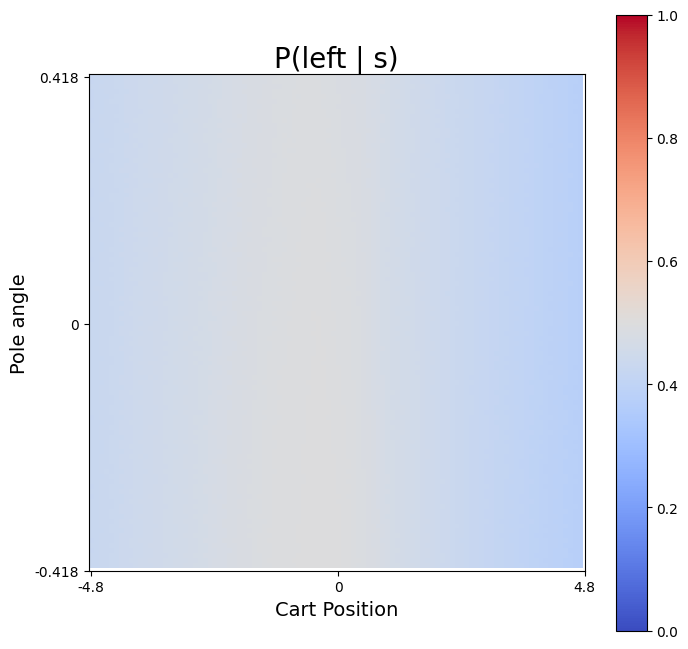

In [6]:
# input_tensor = torch.randn(1, 4).to(device)
policy = GradientPolicy(4, 2).to(device)  # Ensure the policy is on the correct device
grid = plot_policy(policy)

In [7]:
grid

#### Create the environment

In [17]:
env = gym.vector.make("CartPole-v1", num_envs=2)#num_envs is for parallel environments

In [18]:
env.reset()

(array([[ 0.01739393,  0.02777247,  0.04314337, -0.04318944],
        [-0.03424957,  0.01627386,  0.04495842, -0.03164027]],
       dtype=float32),
 {})

In [19]:
env.observation_space, env.action_space

(Box([[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
  [-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]], [[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
  [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]], (2, 4), float32),
 MultiDiscrete([2 2]))

In [21]:
actions = np.array([0, 0])
next_obs, rewards, dones, truncate, infos = env.step(actions)

In [22]:
print(next_obs)
print(rewards)
print(dones)#two values because we have two environments
print(truncate)
print(infos)

[[ 0.01459057 -0.3636399   0.04753533  0.5685003 ]
 [-0.03751335 -0.37518844  0.04982324  0.58120894]]
[1. 1.]
[False False]
[False False]
{}


In [ ]:
next_obs

In [ ]:
rewards

In [ ]:
dones

In [ ]:
infos

In [7]:
def create_env(env_name, num_envs):
  env = gym.vector.make(env_name, num_envs=num_envs)
  env = RecordEpisodeStatistics(env)#recored execution statistics in an array
  env = NormalizeObservation(env)#this will keep a mean and a standard devitation of each of the value in the vector features and normalise each of these values so that they have mean zero
  #and standard deviation 1
  #by doing this, our learning algorithm will eliminate the scale effect of the observations and it will be able to learn more effectively
  env = NormalizeReward(env)#and the same thing we are going to do with the rewards 
  #having very high or very low rewards -100 or 100 can slow our learning process by making our neural network take a big learning step that will actually the quality of our decision making
  #therefore, we are going to normalise those rewards so that the steps that our neural network takes are small and steady and finally we return our environment
  return env

#### Create the dataset

In [8]:
class RLDataset(IterableDataset):

  def __init__(self, env, policy, steps_per_epoch, gamma):#steps_per_epoch is same as samples_per_epoch
    self.env = env
    self.policy = policy
    self.steps_per_epoch = steps_per_epoch
    self.gamma = gamma
    self.obs, _ = env.reset()

  @torch.no_grad()
  def __iter__(self):#it will handle the request for the next element in this dataset
    transitions = []

    for step in range(self.steps_per_epoch):
      action = self.policy(self.obs)
      #we have vector of probabilities for each of the environments
      #[[p1,p2],[q1,q2],....]]->p1, q1, ...is the probability of moving left and p2, q2,... is the probability of going right
      #now out goes is to select based on those probabilities to select one of those actions 
      action = action.multinomial(1).cpu().numpy()#multinomial does that for us. By passsing 1 as parameter, we are telling that we want a single action for each set of probability
      #numpy library because gym library accpets actions as numpy array, not as pytorch tensors
      next_obs, reward, done, truncate, info = self.env.step(action.flatten())#.flatten() because before we had a list of action, like this
      #[[a1],[a2],[a3],...]->a1 is the action selected in the first environment, a2 is the action selected in the 2nd environment
      #but the gym library doesn't want that format, gym library wants a flat list with all the actions as [a1, a2, a3,.....]
      transitions.append((self.obs, action, reward, done))
      self.obs = next_obs
    #but we want to create tensors with all the all obs, one tensor with all the action_b, one tensor with all the reward_b, and finally, another one with the done values
    #the following operation does this
    obs_b, action_b, reward_b, done_b = map(np.stack, zip(*transitions))
    # print(f"This is obs_b {obs_b}")
    # print(f"This is action_b {action_b}")
    # print(f"This is reward_b {reward_b}")
    # print(f"This is done_b {done_b}")
    #*transitions will take the list of transitions and will convert it into a tuple, then with the zip function, we are goint to take the first element of the each transtion, i.e., the transition
    #we are going to stack all those observations, same goes for action, reward, done
    #we have a batch of rewards, but our algorithm doesn't learn based on the reward, but it learns basesd on the returns
    #at each time step, we have to compute the return, which is the discounted sum of all time steps, starting from that time step
    running_return = np.zeros(self.env.num_envs, dtype=np.float32)
    # print(f"This is running_return {running_return}")
    return_b = np.zeros_like(reward_b)
    # print(f"This is reward_b {reward_b}")

    for row in range(self.steps_per_epoch - 1, -1, -1):
      # print(f"This is reward_b[row] {reward_b[row]}")
      running_return = reward_b[row] + (1 - done_b[row]) * self.gamma * running_return
      return_b[row] = running_return
    #Current shape: (3, num_env, num_features) -> (3*num_features, num_features)
    num_samples = self.env.num_envs * self.steps_per_epoch
    obs_b = obs_b.reshape(num_samples, -1)#-1 dimension let's pytorch figure out how many number of columns
    # print(f"This is modified obs_b {obs_b}")
    action_b = action_b.reshape(num_samples, -1)
    # print(f"This is modified action_b {action_b}")
    return_b = return_b.reshape(num_samples, -1)#we need return from every possible state, there are 3 environments and 5 steps in each environment, therefore, total states=15 and 
    #therefore, total number of values in the return_b array will be 15, each row a single entry of the return_b.
    #Refer the output of the cell down below for understanding purposes
    # print(f"This is modified return_b {return_b}")

    #shuffle our observations
    idx = list(range(num_samples))
    random.shuffle(idx)

    for i in idx:
      yield obs_b[i], action_b[i], return_b[i]

DO NOT RUN THE FOLLOWING CELL, IT"S FOR LEARNING PURPPOSES!!!!!!!!

In [64]:
import numpy as np
import torch
from torch.utils.data import IterableDataset
import random

# class MockEnv:
#     def __init__(self, num_envs=1):
#         self.num_envs = num_envs
#         self.observation_space = np.array([4])
#         self.action_space = np.array([2])
#         self.current_step = 0

#     def reset(self):
#         self.current_step = 0
#         return np.zeros((self.num_envs, 4)), {}

#     def step(self, action):
#         self.current_step += 1
#         next_obs = np.ones((self.num_envs, 4)) * self.current_step
#         reward = np.ones(self.num_envs) * self.current_step
#         done = np.array([self.current_step >= 10] * self.num_envs)
#         truncate = np.array([False] * self.num_envs)
#         info = [{}] * self.num_envs
#         return next_obs, reward, done, truncate, info

class MockPolicy:
    def __call__(self, obs):
        return torch.tensor([[0.5, 0.5]] * obs.shape[0])

class RLDataset(IterableDataset):
    def __init__(self, env, policy, steps_per_epoch, gamma):
        self.env = env
        self.policy = policy
        self.steps_per_epoch = steps_per_epoch
        self.gamma = gamma
        self.obs, _ = env.reset()

    @torch.no_grad()
    def __iter__(self):
        transitions = []

        for step in range(self.steps_per_epoch):
            action = self.policy(self.obs)
            action = action.multinomial(1).cpu().numpy()
            next_obs, reward, done, truncate, info = self.env.step(action.flatten())
            transitions.append((self.obs, action, reward, done))
            self.obs = next_obs

        obs_b, action_b, reward_b, done_b = map(np.stack, zip(*transitions))
        print(f"This is obs_b {obs_b}")
        print(f"This is action_b {action_b}")
        print(f"This is reward_b {reward_b}")
        print(f"This is done_b {done_b}")

        running_return = np.zeros(self.env.num_envs, dtype=np.float32)
        print(f"This is running_return {running_return}")
        return_b = np.zeros_like(reward_b)
        print(f"This is return_b {return_b}")

        for row in range(self.steps_per_epoch - 1, -1, -1):
            print(f"This is reward_b[row] {reward_b[row]}")
            running_return = reward_b[row] + (1 - done_b[row]) * self.gamma * running_return
            return_b[row] = running_return

        num_samples = self.env.num_envs * self.steps_per_epoch
        obs_b = obs_b.reshape(num_samples, -1)
        print(f"This is modified obs_b {obs_b}")
        action_b = action_b.reshape(num_samples, -1)
        print(f"This is modified action_b {action_b}")
        return_b = return_b.reshape(num_samples, -1)
        print(f"This is modified return_b {return_b}")

        idx = list(range(num_samples))
        random.shuffle(idx)

        for i in idx:
            yield obs_b[i], action_b[i], return_b[i]

# Create mock environment and policy
env = create_env("CartPole-v1",num_envs=3)
policy = MockPolicy()

# Create the dataset
dataset = RLDataset(env, policy, steps_per_epoch=5, gamma=0.99)

# Run the __iter__ method
for data in dataset:
    print(data)


/home/akhters/.local/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


This is obs_b [[[-0.69243001  1.36970724  1.36347102 -1.01450635]
  [ 1.26436472 -0.88989816 -0.4955398  -0.30159296]
  [-0.57221619 -0.47984489 -0.86792987  1.31609304]]

 [[-0.67940649  1.72700868  1.36995279 -1.70064507]
  [ 1.29787153 -1.21709403 -0.51216482  1.10734878]
  [-0.64635648 -1.13395819 -0.85967191  1.29311867]]

 [[-0.27829606  2.12265125  1.19438201 -2.12730629]
  [ 1.0195139  -0.25441938 -0.34700549  0.06266832]
  [-1.02899783 -0.18655113 -0.68938228  0.20081088]]

 [[ 0.44688454  1.03529461  0.79960335 -0.90512376]
  [ 0.95300559 -1.29383783 -0.36460447  1.22677231]
  [-1.13775485  0.75305139 -0.70561042 -0.87051074]]

 [[ 0.85716526  0.08577655  0.61244363  0.21328001]
  [ 0.51529798 -0.30067032 -0.08733134  0.07570797]
  [-0.90778254 -0.2253754  -0.98314471  0.20749125]]]
This is action_b [[[1]
  [0]
  [0]]

 [[1]
  [1]
  [1]]

 [[0]
  [0]
  [1]]

 [[0]
  [1]
  [0]]

 [[0]
  [1]
  [1]]]
This is reward_b [[122.46836374 122.46836374 122.46836374]
 [  2.01999658   2.0

#### Create the REINFORCE algorithm

In [9]:
class Reinforce(LightningModule):

  def __init__(self, env_name, num_envs=8, samples_per_epoch=1000, batch_size=512, 
               hidden_size=64, policy_lr=0.001, gamma=0.99, entropy_coef=0.001, optim=AdamW):
    
    super().__init__()

    self.env = create_env(env_name, num_envs=num_envs)

    obs_size = self.env.single_observation_space.shape[0]#this method, single_observation_space allows us to grab the observation space of a single environmnet and the number of features
    #will be the first value in that array
    n_actions = self.env.single_action_space.n

    self.policy = GradientPolicy(obs_size, n_actions, hidden_size)
    self.dataset = RLDataset(self.env, self.policy, samples_per_epoch, gamma)

    self.save_hyperparameters()#so that we can access each of the parameters passed in the __init__ anywhere in the code

  # Configure optimizers.
  def configure_optimizers(self):
    return self.hparams.optim(self.policy.parameters(), lr=self.hparams.policy_lr)

  def train_dataloader(self):
     #The __iter__ method of the RLDataset class is called each time the dataset is iterated over. In the context of the provided code, this happens every time a new batch of data is requested by the DataLoader during the training loop. Here’s how you can confirm that the __iter__ method is called more than once:

# Training Loop in PyTorch Lightning:
# PyTorch Lightning handles the training loop for you. During training, it will call the train_dataloader method to get the DataLoader and then iterate over it to get batches of data. Each epoch of training will involve multiple calls to __iter__ if your batch size is smaller than the number of samples.
# 
# Logging in the __iter__ Method:
# You can add a print statement or logging inside the __iter__ method to see when it is being called. 
    return DataLoader(dataset=self.dataset, batch_size=self.hparams.batch_size)

  # Training step.
  def training_step(self, batch, batch_idx):
    obs, actions, returns = batch

    probs = self.policy(obs)
    # print(f"This is the probs {probs}")
    log_probs = torch.log(probs + 1e-6)#1e-6 is added for stability
    # print(f"This is the log_probs {log_probs}")
    action_log_prob = log_probs.gather(1, actions)#now, we are taking the log of probablilites that we actually took
    # print(f"This is the action_log_prob {action_log_prob}")

    entropy = - torch.sum(probs * log_probs, dim=-1, keepdim=True)
    # print(f"This is the entropy {entropy}")

    pg_loss = - action_log_prob * returns
    loss = (pg_loss - self.hparams.entropy_coef * entropy).mean()#entropy+coef ->The higher this coefficient, the higher we are encouraging for exploration

    self.log("episode/PG Loss", pg_loss.mean())
    self.log("episode/Entropy", entropy.mean())

    return loss
  
  def on_train_epoch_end(self):
    self.log("episode/Return", self.env.return_queue[-1])

#### Purge logs and run the visualization tool (Tensorboard)

In [13]:
!rm -r /content/lightning_logs/
!rm -r /content/videos/
%load_ext tensorboard
%tensorboard --logdir /content/lightning_logs/

rm: cannot remove '/content/lightning_logs/': No such file or directory
rm: cannot remove '/content/videos/': No such file or directory
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


ERROR: Failed to start `tensorboard`: [Errno 8] Exec format error:
'tensorboard'

#### Train the policy

In [10]:
algo = Reinforce('CartPole-v1')

trainer = Trainer(
  # gpus=num_gpus,
  max_epochs=1000,
  log_every_n_steps=1
)

trainer.fit(algo)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
2024-07-07 18:42:35.641872: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-07 18:42:36.643314: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type           | 

Training: |          | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_3894/583707354.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).float().to(device)
`Trainer.fit` stopped: `max_epochs=1000` reached.


#### Check the resulting policy

In [34]:
import warnings
# warnings.filterwarnings('ignore')

test_env('CartPole-v1', algo.policy, algo.env.obs_rms)

0
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


/home/akhters/.local/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_pg_methods_complete/videos/rl-video-episode-0.mp4
True
1
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fal

Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_pg_methods_complete/videos/rl-video-episode-1.mp4
True
2
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fal

Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_pg_methods_complete/videos/rl-video-episode-2.mp4
True
3
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fal

Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_pg_methods_complete/videos/rl-video-episode-3.mp4
True
4
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fal

Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_pg_methods_complete/videos/rl-video-episode-4.mp4
True
5
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fal

Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_pg_methods_complete/videos/rl-video-episode-5.mp4
True
6
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fal

Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_pg_methods_complete/videos/rl-video-episode-6.mp4
True
7
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fal

Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_pg_methods_complete/videos/rl-video-episode-7.mp4
True
8
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fal

Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_pg_methods_complete/videos/rl-video-episode-8.mp4
True
9
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fal

Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_pg_methods_complete/videos/rl-video-episode-9.mp4
True


In [ ]:
display_video(episode=1)

#### Plot the trained policy

/tmp/ipykernel_3894/583707354.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).float().to(device)


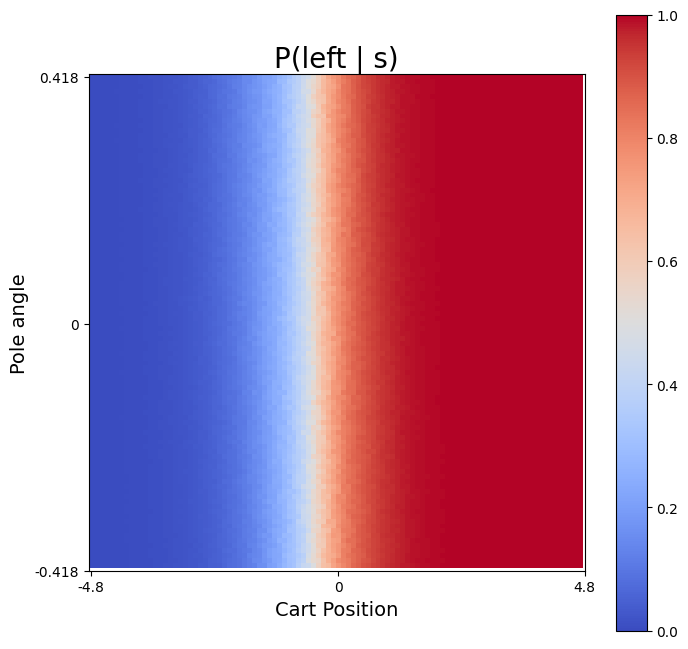

In [27]:
plot_policy(algo.policy)

In [24]:
algo.policy.to(device)

GradientPolicy(
  (fc1): Linear(in_features=4, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
)

In [25]:
device = next(algo.policy.parameters()).device

In [26]:
device

device(type='cuda', index=0)